## Tutorial on REPOP -- REconstruct POpulations from Plates

This tutorial provides a step-by-step guide on using the `repop` software package. 


The package processes sequences of counts and dilution factors obtained through plate counting to reconstruct population distributions.
For installation and setup, please refer to the repository README.

In [1]:
import torch
import repop
import pandas as pd
from matplotlib import pyplot as plt

## Model 1 — Unimodal Without Threshold

### Main usage
First, we need to retrieve the count data and corresponding dilution factors.

For this tutorial, we will use a synthetic dataset (`synth_unimodal`) containing 1,000 data points.

For details on generating synthetic data, refer to the repository README. 
For now, let's load the data using `pandas`.



In [2]:
filename = 'synth_data/synth_unimodal.csv'
df=pd.read_csv(filename)[:1000]
df

,Counts,Dilution
0,32,200
1,39,200
2,42,200
3,46,200
4,48,200
...,...,...
995,46,200
996,38,200
997,34,200
998,32,200


### Extracting Counts and Dilution Factors
To ensure `repop` correctly associates dilution factors with counts, we must preserve their order.

Below, we extract both as `numpy` arrays and display the first five elements of each:

In [3]:
cts  = df['Counts'].to_numpy()
dils = df['Dilution'].to_numpy().astype(float)
cts[:5],dils[:5]

(array([32, 39, 42, 46, 48]), array([200., 200., 200., 200., 200.]))

### Creating a Dataset Object
To use `repop`, we first initialize a `dataset` object with the extracted counts and dilution factors.

In [4]:
data = repop.dataset(cts,dils)

### Reconstructing the Distribution
To reconstruct the population distribution, we use the `evaluate` function. 

Since we know that our synthetic dataset represents a unimodal distribution, we set `components=1`. (We will explore multimodal cases later.) 

In our benchmark, this process ~ 10 s.

In [5]:
data.evaluate(components=1)

(tensor([7943.7106], device='cuda:0', dtype=torch.float64),
 tensor([529.6136], device='cuda:0', dtype=torch.float64),
 tensor([1.], device='cuda:0', dtype=torch.float64))

The printed output corresponds to:
- **Means**: The estimated center of the Gaussian component.
- **Standard Deviations**: The spread of the distribution.
- **Weights**: The proportion of each component in the mixture.


Since we are using a single-component model (`components=1`), we obtain one value for each parameter.  
For multimodal distributions, these parameters will be arrays, with weights summing to 1.


### Visualizing the Reconstruction
Once `data.evaluate()` is executed, we can visualize the reconstructed population distribution using the `make_plot` method


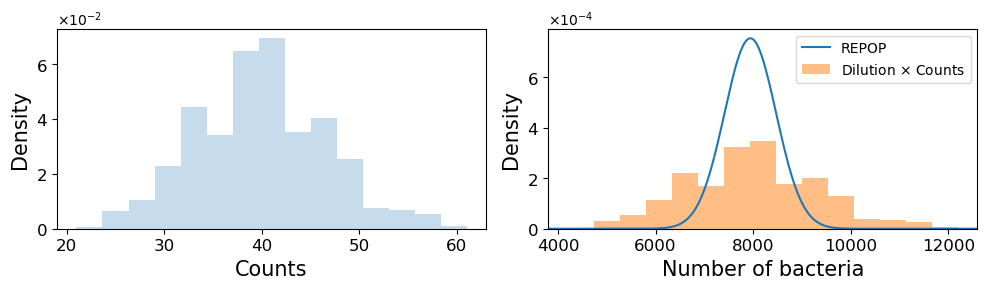

In [6]:
data.make_plot('graphs/synth/unimodal.png')
plt.show()

### Comparing to Ground Truth
Since this dataset is synthetic, we know it was generated using a single Gaussian with mean $8000$ and standard deviation $500$.

The estimated values from our model are very close to these ground truth parameters (see output in line 5).  
To visualize the difference between the estimated and true distribution on the same plot, we can use the `set_gt` function and pass it as a parameter in `make_plot`, as shown below:


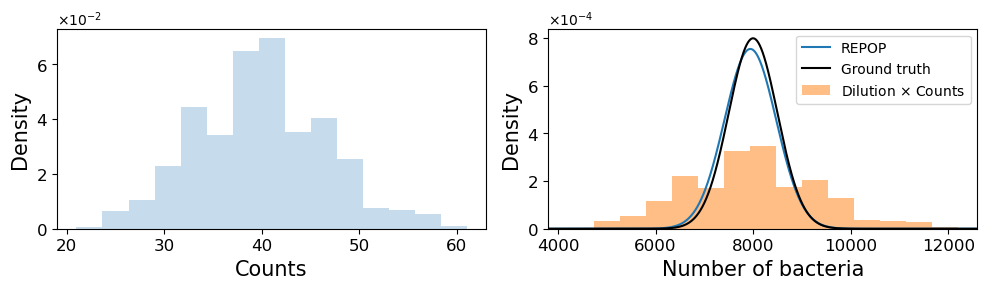

In [7]:
gt = repop.set_gt(8000,500,1)
data.make_plot('graphs/synth/unimodal.png',gt)
plt.show()

### Extracting the Reconstructed Probability Density Function

Here, it is interesting to mention that in `repop` we can also obtain the reconstructed probability density function (PDF) in terms of bacterial counts. This allows us to save the results for further applications.
To do this, we use the function `get_reconstruction`, which returns `n, p` as an array. This output can be used independently outside the `data` object.
For visualization, let's plot the reconstructed distribution separately, without relying on the `data` object.


In [8]:
n,p = data.get_reconstruction()
n,p

(tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 2.4398e+04, 2.4399e+04,
         2.4400e+04]),
 tensor([ 1.0894e-52,  1.1207e-52,  1.1529e-52,  ..., 1.8858e-213,
         1.7784e-213, 1.6771e-213], dtype=torch.float64))

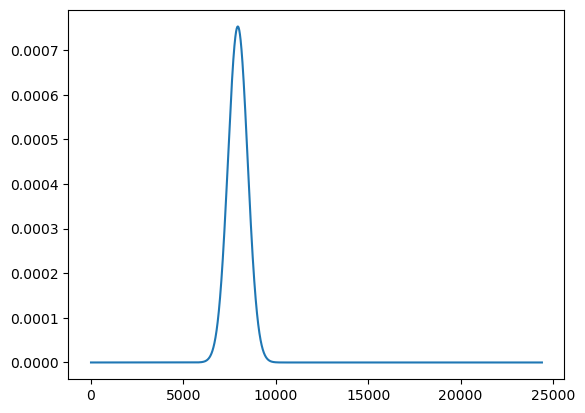

In [9]:
plt.plot(n,p)
plt.show()

While this graph is not as insightfull. The fact that we extract `n` and `p` are useful as they can be saved and used in other applications for further analysis or integration into different workflows.

## Model 2 — Multimodal and Without Threshold

In this section, we extend the analysis to a more complex dataset that contains multiple underlying populations, following **Model 2**, as defined in the manuscript.

We begin by loading the dataset `synth_multimodal_harder.csv` in the `data2` object of `dataset`.

In [10]:
filename = 'synth_data/synth_multimodal_harder.csv'
df   = pd.read_csv(filename)[:1000]
cts  = df['Counts'].to_numpy()
dils = df['Dilution'].to_numpy().astype(float)
data2 = repop.dataset(cts,dils)

Since this dataset is synthetic, we also know the true underlying distribution. In order to pass it to the `data2` object we can:

In [11]:
gt2 = repop.set_gt((4000,8000,14000),(200,1500,1000),(.25,.4,.35))

     

### Performing the Reconstruction

Similar to Model 1, we obtain the reconstruction using the `evaluate` (took ~ 20s in our benchmark)

In [12]:
data2.evaluate()

(tensor([14059.3577, 14043.5783,  3976.5510,  7981.5001,  3985.9396,  7957.3844,
          7933.7066, 13677.9381,  7813.8701, 11355.3173,  7620.6154, 10543.7393,
         10358.5741,  4037.4648,  4039.7593,  6778.7086,  4029.0558,  4009.7388,
          3977.3548,  3934.8518,  4956.8177,  4987.5699,  4865.2191],
        device='cuda:0', dtype=torch.float64),
 tensor([ 898.1102,  956.3943,  378.6279,  887.7174,  415.6050, 1025.6121,
         1121.7480, 1802.4719, 1433.2988, 2886.5604, 1646.7968, 2880.3628,
         2881.2398,  650.9857,  685.7807, 1749.7673,  757.6786,  792.4565,
          824.7411,  857.0253, 1412.3024, 1479.9734, 1497.7183],
        device='cuda:0', dtype=torch.float64),
 tensor([0.1311, 0.1169, 0.0887, 0.0853, 0.0706, 0.0675, 0.0598, 0.0562, 0.0467,
         0.0422, 0.0364, 0.0329, 0.0291, 0.0236, 0.0206, 0.0191, 0.0157, 0.0136,
         0.0117, 0.0100, 0.0087, 0.0074, 0.0062], device='cuda:0',
        dtype=torch.float64))

Unlike before, where we had a single component, this dataset follows a non-parametric approach, as described in the manuscript. 

Although the ground truth defines a trimodal structure, the reconstruction may yield additional peaks. This is not a flaw, but rather a natural consequence of non-parametric methods. Unlike parametric models that enforce a fixed number of Gaussians, non-parametric methods dynamically adapt based on the observed data.

As a result, instead of estimating a fixed number of means, standard deviations, and weights, the method allows for a potentially infinite number of close-by peaks. This reflects the limited amount of data available and the flexibility of the approach. This can be seen in the results above. While the true mean is 14000, the model might estimate nearby peaks at 14059.3577 and 14043.5783. These small variations arise naturally due to finite sample size.

This is not a problem, as the overall shape of the distribution remains consistent with the expected structure. Despite the presence of additional nearby peaks, we still effectively observe the trimodal structure, as can be seen with the `make_plot` method



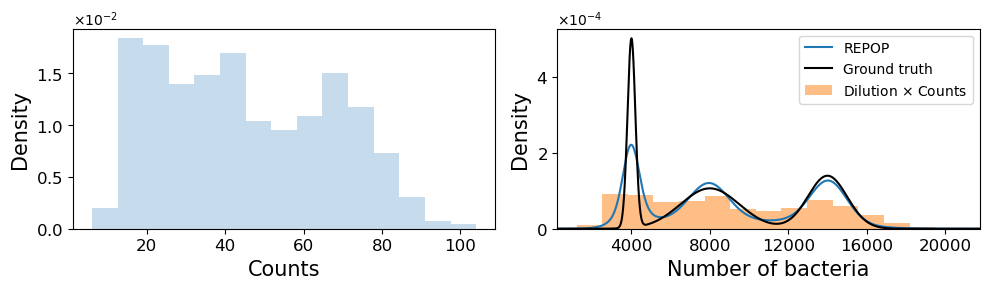

In [13]:
data2.make_plot('graphs/synth/multimodal_harder.png',gt2)
plt.show()

## Model 3 — Multimodal With Threshold


In this section, we introduce a threshold in the reconstruction process. Unlike the previous models, we assume that the experimentalist followed plate counting with a threshold and recorded the smallest dilution factor where the bacterial count was below the threshold. More details can be found in the manuscript (Sec. 2.4.2).

We begin by loading 500 data points from the dataset `synth_case3.csv`


In [14]:
filename = 'synth_data/synth_case3.csv'
th_gt = repop.set_gt((6000,30000,60000),(1200,3600,9600),(.4,.2,.4))

df   = pd.read_csv(filename)[:500]
cts  = df['Counts'].to_numpy()
dils = df['Dilution'].to_numpy().astype(float)

This process assumes that, at every dilution step, all previous smaller dilutions produced plates with bacterial counts higher than the threshold.

Since this is synthetic data, we know the threshold used in its creation. To verify this, check the script that generates the synthetic dataset `synth_data/cases.py`.

Now, we initialize the `dataset`   object setting the `threshold` variable:

In [15]:
data3 = repop.dataset(cts,dils,threshold=300)

now, we obtain the reconstruction using the `evaluate` method as before

In [16]:
data3.evaluate()

(tensor([ 5685.6564,  5682.6377,  6696.2036, 59984.0125, 60085.4914, 59983.3210,
         59723.7431, 29443.7737, 58720.8533, 63161.7923, 57026.5639, 29473.3080,
         55252.6842, 29635.0093, 29818.7414, 30150.0025, 30790.8980, 47765.7044,
         35989.5917, 32091.8032, 31227.5565], device='cuda:0',
        dtype=torch.float64),
 tensor([ 1365.1213,   666.2315,   948.0668,  4945.1192,  5807.9905,  6586.4830,
          7336.6865,  2342.6756,  8971.1725, 15722.6348, 10727.4705,  2969.7073,
         11807.7185,  3503.9925,  3891.9556,  4414.1977,  5163.9213, 12578.9907,
          8830.1811,  7255.7310,  7473.8198], device='cuda:0',
        dtype=torch.float64),
 tensor([0.1421, 0.1309, 0.1192, 0.0862, 0.0756, 0.0664, 0.0583, 0.0491, 0.0447,
         0.0375, 0.0341, 0.0286, 0.0259, 0.0212, 0.0180, 0.0152, 0.0127, 0.0120,
         0.0090, 0.0074, 0.0059], device='cuda:0', dtype=torch.float64))

and visualize the reconstruction with  `make_plot`

/home/pessoa/Codes/CElegans-Plate/repop.py:335: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ax.get_xticks() * bins[-1]).astype(int))


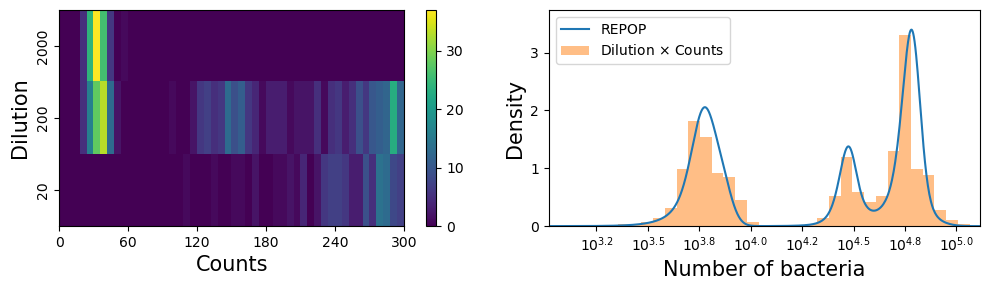

In [17]:
data3.make_plot()
plt.show()

When working with different dilution factors, REPOP defaults to displaying multiple layers of count values. Instead of a traditional histogram on the left hand side and a log scale plot on the right hand side, the visualization adapts to represent the layered dilution counts effectively.